# Exploring Neural Audio Synthesis with NSynth

## Parag Mital

There is a lot to explore with NSynth.  This colab explores just a taste of what's possible including how to encode and decode, timestretch, and interpolate sounds.  Also check out the [blog post](https://magenta.tensorflow.org/nsynth-fastgen) for more examples including two compositions created with Ableton Live.  If you are interested in learning more, checkout my [online course on Kadenze](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow) where we talk about Magenta and NSynth in more depth.

NOTE: This colab is connected to a GPU kernel!

## Part 1: Encoding and Decoding

We'll walkthrough using the source code to encode and decode some audio.  This is the most basic thing we can do with NSynth, and it will take at least about 6 minutes per 1 second of audio to perform on a GPU, though this will get faster!

I'll first show you how to encode some audio.  This is basically saying, here is some audio, now put it into the trained model.  It's like the encoding of an MP3 file.  It takes some raw audio, and represents it using some really reduced down representation of the raw audio.  NSynth works similarly, but we can actually mess with the encoding to do some awesome stuff.  You can for instance, mix it with other encodings, or slow it down, or speed it up.  You can potentially even remove parts of it, mix many different encodings together, and hopefully just explore ideas yet to be thought of.  After you've created your encoding, you have to just generate, or decode it, just like what an audio player does to an MP3 file.

First, to install Magenta, follow their setup guide here: https://github.com/tensorflow/magenta#installation - then import some packages:

In [0]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.test.gpu_device_name())
print(device_lib.list_local_devices())

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13905209785131673654
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 358350848
locality {
  bus_id: 1
}
incarnation: 17815337860535073741
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
!apt-get install -y libav-tools libasound2-dev libsndfile1-dev libjack-dev
import os
import numpy as np
import matplotlib.pyplot as plt
!pip install magenta
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from IPython.display import Audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libasound2-dev is already the newest version (1.1.3-5).
libsndfile1-dev is already the newest version (1.0.28-4).
libav-tools is already the newest version (7:3.3.4-2).
libjack-dev is already the newest version (1:0.125.0-2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Now we'll load up a sound I downloaded from freesound.org.  The `utils.load_audio` method will resample this to the required sample rate of 16000.  I'll load in 64000 samples of this beat which should end up being a pretty good loop:

In [0]:
# from https://archive.org/details/108_bpm_breakbeat_to_use
!wget https://archive.org/download/108_bpm_breakbeat_to_use/Sample00_108_BPM_EatMe_drums_-_2016_-_samples_-_music_by_EatMe_-_www.eatme.pro_-_drums_recorded_with_2_overhead_microphones_through_mix_amp_on_minidisc_to_computer..wav -O breakbeat.wav
fname = 'breakbeat.wav'
sr = 16000
audio = utils.load_audio(fname, sample_length=64000, sr=sr)
sample_length = audio.shape[0]
print('{} samples, {} seconds'.format(sample_length, sample_length / float(sr)))

--2018-01-19 23:41:28--  https://archive.org/download/108_bpm_breakbeat_to_use/Sample00_108_BPM_EatMe_drums_-_2016_-_samples_-_music_by_EatMe_-_www.eatme.pro_-_drums_recorded_with_2_overhead_microphones_through_mix_amp_on_minidisc_to_computer..wav
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801907.us.archive.org/32/items/108_bpm_breakbeat_to_use/Sample00_108_BPM_EatMe_drums_-_2016_-_samples_-_music_by_EatMe_-_www.eatme.pro_-_drums_recorded_with_2_overhead_microphones_through_mix_amp_on_minidisc_to_computer..wav [following]
--2018-01-19 23:41:28--  https://ia801907.us.archive.org/32/items/108_bpm_breakbeat_to_use/Sample00_108_BPM_EatMe_drums_-_2016_-_samples_-_music_by_EatMe_-_www.eatme.pro_-_drums_recorded_with_2_overhead_microphones_through_mix_amp_on_minidisc_to_computer..wav
Resolving ia801907.us.archive.org (ia801907.us.archive.org)

In [0]:
Audio(audio, rate=sr)

## Encoding

We'll now encode some audio using the pre-trained NSynth model (download from: http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar).  This is pretty fast, and takes about 3 seconds per 1 second of audio on my NVidia 1080 GPU.  This will give us a 125 x 16 dimension encoding for every 4 seconds of audio which we can then decode, or resynthesize.  We'll try a few things, including just leaving it alone and reconstructing it as is.  But then we'll also try some fun transformations of the encoding and see what's possible from there.

```help(fastgen.encode)
Help on function encode in module magenta.models.nsynth.wavenet.fastgen:

encode(wav_data, checkpoint_path, sample_length=64000)
    Generate an array of embeddings from an array of audio.
      Args:
        wav_data: Numpy array [batch_size, sample_length]
        checkpoint_path: Location of the pretrained model.
        sample_length: The total length of the final wave file, padded with 0s.
      Returns:
        encoding: a [mb, 125, 16] encoding (for 64000 sample audio file).
```

In [0]:
if not os.path.exists('model.ckpt-200000.meta'):
  !wget  http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar && tar -xvf wavenet-ckpt.tar && mv wavenet-ckpt/model* .

--2018-01-19 23:41:31--  http://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar
Resolving download.magenta.tensorflow.org (download.magenta.tensorflow.org)... 74.125.28.128, 2607:f8b0:400e:c04::80
Connecting to download.magenta.tensorflow.org (download.magenta.tensorflow.org)|74.125.28.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 993896960 (948M) [application/x-tar]
Saving to: ‘wavenet-ckpt.tar.4’

wavenet-ckpt.tar.4  100%[===================>] 947.85M   306MB/s    in 3.3s    

2018-01-19 23:41:35 (290 MB/s) - ‘wavenet-ckpt.tar.4’ saved [993896960/993896960]

./._wavenet-ckpt
wavenet-ckpt/
wavenet-ckpt/checkpoint
wavenet-ckpt/._model.ckpt-200000.data-00000-of-00001
wavenet-ckpt/model.ckpt-200000.data-00000-of-00001
wavenet-ckpt/._model.ckpt-200000.index
wavenet-ckpt/model.ckpt-200000.index
wavenet-ckpt/._model.ckpt-200000.meta
wavenet-ckpt/model.ckpt-200000.meta


In [0]:
encoding = fastgen.encode(audio, 'model.ckpt-200000', sample_length=sample_length)

INFO:tensorflow:Restoring parameters from model.ckpt-200000


This returns a 3-dimensional tensor representing the encoding of the audio.  The first dimension of the encoding represents the batch dimension.  We could have passed in many audio files at once and the process would be much faster.  For now we've just passed in one audio file.

In [0]:
print(encoding.shape)

(1, 125, 16)


We'll also save the encoding so that we can use it again later:

In [0]:
np.save(fname + '.npy', encoding)

Let's take a look at the encoding of this audio file.  Think of these as 16 channels of sounds all mixed together (though with a lot of caveats):

Text(0.5,1,'NSynth Encoding')

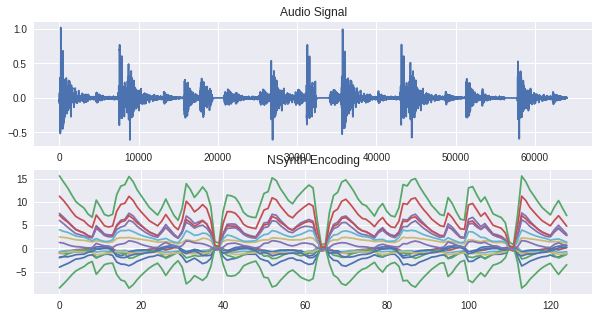

In [0]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding[0]);
axs[1].set_title('NSynth Encoding')

You should be able to pretty clearly see a sort of beat like pattern in both the signal and the encoding.

## Decoding

Now we can decode the encodings as is.  This is the process that takes awhile, though it used to be so long that you wouldn't even dare trying it.  There is still plenty of room for improvement and I'm sure it will get faster very soon.

```
help(fastgen.synthesize)
Help on function synthesize in module magenta.models.nsynth.wavenet.fastgen:

synthesize(encodings, save_paths, checkpoint_path='model.ckpt-200000', samples_per_save=1000)
    Synthesize audio from an array of embeddings.
      Args:
        encodings: Numpy array with shape [batch_size, time, dim].
        save_paths: Iterable of output file names.
        checkpoint_path: Location of the pretrained model. [model.ckpt-200000]
        samples_per_save: Save files after every amount of generated samples.
```        

In [0]:
fastgen.synthesize(encoding,
                   save_paths=['gen_' + fname],
                   samples_per_save=sample_length)

INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: gen_breakbeat.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800
INFO:tensorflow:Sample: 2900
INFO:tensorflow:Sample: 3000
INFO:tensor

INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorflow:Sample: 10000
INFO:tensorflow:Sample: 10100
INFO:tensorflow:Sample: 10200
INFO:tensorflow:Sample: 10300
INFO:tensorflow:Sample: 10400
INFO:tensorflow:Sample: 10500
INFO:tensorflow:Sample: 10600
INFO:tensorflow:Sample: 10700
INFO:tensorflow:Sample: 10800
INFO:tensorflow:Sample: 10900
INFO:tensorflow:Sample: 11000
INFO:tensorflow:Sample: 11100
INFO:tensorflow:Sample: 11200
I

INFO:tensorflow:Sample: 16000
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Sample: 17100
INFO:tensorflow:Sample: 17200
INFO:tensorflow:Sample: 17300
INFO:tensorflow:Sample: 17400
INFO:tensorflow:Sample: 17500
INFO:tensorflow:Sample: 17600
INFO:tensorflow:Sample: 17700
INFO:tensorflow:Sample: 17800
INFO:tensorflow:Sample: 17900
INFO:tensorflow:Sample: 18000
INFO:tensorflow:Sample: 18100
INFO:tensorflow:Sample: 18200
INFO:tensorflow:Sample: 18300
INFO:tensorflow:Sample: 18400
INFO:tensorflow:Sample: 18500
INFO:tensorflow:Sample: 18600
INFO:tensorflow:Sample: 18700
INFO:tensorflow:Sample: 18800
INFO:tensorflow:Sample: 18900
INFO:tensorflow:Sample: 19000
INFO:tensorflow:Sample: 19100
INFO:tensorflow:Sample: 19200
INFO:tenso

INFO:tensorflow:Sample: 24100
INFO:tensorflow:Sample: 24200
INFO:tensorflow:Sample: 24300
INFO:tensorflow:Sample: 24400
INFO:tensorflow:Sample: 24500
INFO:tensorflow:Sample: 24600
INFO:tensorflow:Sample: 24700
INFO:tensorflow:Sample: 24800
INFO:tensorflow:Sample: 24900
INFO:tensorflow:Sample: 25000
INFO:tensorflow:Sample: 25100
INFO:tensorflow:Sample: 25200
INFO:tensorflow:Sample: 25300
INFO:tensorflow:Sample: 25400
INFO:tensorflow:Sample: 25500
INFO:tensorflow:Sample: 25600
INFO:tensorflow:Sample: 25700
INFO:tensorflow:Sample: 25800
INFO:tensorflow:Sample: 25900
INFO:tensorflow:Sample: 26000
INFO:tensorflow:Sample: 26100
INFO:tensorflow:Sample: 26200
INFO:tensorflow:Sample: 26300
INFO:tensorflow:Sample: 26400
INFO:tensorflow:Sample: 26500
INFO:tensorflow:Sample: 26600
INFO:tensorflow:Sample: 26700
INFO:tensorflow:Sample: 26800
INFO:tensorflow:Sample: 26900
INFO:tensorflow:Sample: 27000
INFO:tensorflow:Sample: 27100
INFO:tensorflow:Sample: 27200
INFO:tensorflow:Sample: 27300
INFO:tenso

INFO:tensorflow:Sample: 32200
INFO:tensorflow:Sample: 32300
INFO:tensorflow:Sample: 32400
INFO:tensorflow:Sample: 32500
INFO:tensorflow:Sample: 32600
INFO:tensorflow:Sample: 32700
INFO:tensorflow:Sample: 32800
INFO:tensorflow:Sample: 32900
INFO:tensorflow:Sample: 33000
INFO:tensorflow:Sample: 33100
INFO:tensorflow:Sample: 33200
INFO:tensorflow:Sample: 33300
INFO:tensorflow:Sample: 33400
INFO:tensorflow:Sample: 33500
INFO:tensorflow:Sample: 33600
INFO:tensorflow:Sample: 33700
INFO:tensorflow:Sample: 33800
INFO:tensorflow:Sample: 33900
INFO:tensorflow:Sample: 34000
INFO:tensorflow:Sample: 34100
INFO:tensorflow:Sample: 34200
INFO:tensorflow:Sample: 34300
INFO:tensorflow:Sample: 34400
INFO:tensorflow:Sample: 34500
INFO:tensorflow:Sample: 34600
INFO:tensorflow:Sample: 34700
INFO:tensorflow:Sample: 34800
INFO:tensorflow:Sample: 34900
INFO:tensorflow:Sample: 35000
INFO:tensorflow:Sample: 35100
INFO:tensorflow:Sample: 35200
INFO:tensorflow:Sample: 35300
INFO:tensorflow:Sample: 35400
INFO:tenso

INFO:tensorflow:Sample: 40300
INFO:tensorflow:Sample: 40400
INFO:tensorflow:Sample: 40500
INFO:tensorflow:Sample: 40600
INFO:tensorflow:Sample: 40700
INFO:tensorflow:Sample: 40800
INFO:tensorflow:Sample: 40900
INFO:tensorflow:Sample: 41000
INFO:tensorflow:Sample: 41100
INFO:tensorflow:Sample: 41200
INFO:tensorflow:Sample: 41300
INFO:tensorflow:Sample: 41400
INFO:tensorflow:Sample: 41500
INFO:tensorflow:Sample: 41600
INFO:tensorflow:Sample: 41700
INFO:tensorflow:Sample: 41800
INFO:tensorflow:Sample: 41900
INFO:tensorflow:Sample: 42000
INFO:tensorflow:Sample: 42100
INFO:tensorflow:Sample: 42200
INFO:tensorflow:Sample: 42300
INFO:tensorflow:Sample: 42400
INFO:tensorflow:Sample: 42500
INFO:tensorflow:Sample: 42600
INFO:tensorflow:Sample: 42700
INFO:tensorflow:Sample: 42800
INFO:tensorflow:Sample: 42900
INFO:tensorflow:Sample: 43000
INFO:tensorflow:Sample: 43100
INFO:tensorflow:Sample: 43200
INFO:tensorflow:Sample: 43300
INFO:tensorflow:Sample: 43400
INFO:tensorflow:Sample: 43500
INFO:tenso

INFO:tensorflow:Sample: 48400
INFO:tensorflow:Sample: 48500
INFO:tensorflow:Sample: 48600
INFO:tensorflow:Sample: 48700
INFO:tensorflow:Sample: 48800
INFO:tensorflow:Sample: 48900
INFO:tensorflow:Sample: 49000
INFO:tensorflow:Sample: 49100
INFO:tensorflow:Sample: 49200
INFO:tensorflow:Sample: 49300
INFO:tensorflow:Sample: 49400
INFO:tensorflow:Sample: 49500
INFO:tensorflow:Sample: 49600
INFO:tensorflow:Sample: 49700
INFO:tensorflow:Sample: 49800
INFO:tensorflow:Sample: 49900
INFO:tensorflow:Sample: 50000
INFO:tensorflow:Sample: 50100
INFO:tensorflow:Sample: 50200
INFO:tensorflow:Sample: 50300
INFO:tensorflow:Sample: 50400
INFO:tensorflow:Sample: 50500
INFO:tensorflow:Sample: 50600
INFO:tensorflow:Sample: 50700
INFO:tensorflow:Sample: 50800
INFO:tensorflow:Sample: 50900
INFO:tensorflow:Sample: 51000
INFO:tensorflow:Sample: 51100
INFO:tensorflow:Sample: 51200
INFO:tensorflow:Sample: 51300
INFO:tensorflow:Sample: 51400
INFO:tensorflow:Sample: 51500
INFO:tensorflow:Sample: 51600
INFO:tenso

INFO:tensorflow:Sample: 56500
INFO:tensorflow:Sample: 56600
INFO:tensorflow:Sample: 56700
INFO:tensorflow:Sample: 56800
INFO:tensorflow:Sample: 56900
INFO:tensorflow:Sample: 57000
INFO:tensorflow:Sample: 57100
INFO:tensorflow:Sample: 57200
INFO:tensorflow:Sample: 57300
INFO:tensorflow:Sample: 57400
INFO:tensorflow:Sample: 57500
INFO:tensorflow:Sample: 57600
INFO:tensorflow:Sample: 57700
INFO:tensorflow:Sample: 57800
INFO:tensorflow:Sample: 57900
INFO:tensorflow:Sample: 58000
INFO:tensorflow:Sample: 58100
INFO:tensorflow:Sample: 58200
INFO:tensorflow:Sample: 58300
INFO:tensorflow:Sample: 58400
INFO:tensorflow:Sample: 58500
INFO:tensorflow:Sample: 58600
INFO:tensorflow:Sample: 58700
INFO:tensorflow:Sample: 58800
INFO:tensorflow:Sample: 58900
INFO:tensorflow:Sample: 59000
INFO:tensorflow:Sample: 59100
INFO:tensorflow:Sample: 59200
INFO:tensorflow:Sample: 59300
INFO:tensorflow:Sample: 59400
INFO:tensorflow:Sample: 59500
INFO:tensorflow:Sample: 59600
INFO:tensorflow:Sample: 59700
INFO:tenso

After it's done synthesizing, we can see that takes about 6 minutes per 1 second of audio on a non-optimized version of Tensorflow for GPU on an NVidia 1080 GPU.  We can speed things up considerably if we want to do multiple encodings at a time.  We'll see that in just a moment.  Let's first listen to the synthesized audio:

In [0]:
sr = 16000
synthesis = utils.load_audio(
    'gen_' + fname,
    sample_length=sample_length,
    sr=sr)

In [0]:
Audio(synthesis, rate=sr)

Listening to the audio, the sounds are definitely different.  NSynth seems to apply a sort of gobbly low-pass  that also really doesn't know what to do with the high frequencies.  It is really quite hard to describe, but that is what is so interesting about it.  It has a recognizable, characteristic sound.

Let's try another one.  I'll put the whole workflow for synthesis in two cells, and we can listen to another synthesis of a cello:

In [0]:
def load_encoding(fname, sample_length=None, sr=16000, ckpt='model.ckpt-200000'):
    audio = utils.load_audio(fname, sample_length=sample_length, sr=sr)
    encoding = fastgen.encode(audio, ckpt, sample_length)
    return audio, encoding

In [0]:
# from https://archive.org/details/CelloSuitesNo.1InGBwv10074.sarabande
!wget https://archive.org/download/CelloSuitesNo.1InGBwv10074.sarabande/04No.1InGBwv1007_4.Sarabandelento.ogg -O cello.ogg
!ffmpeg -i cello.ogg -y cello.wav
fname = 'cello.wav'
sample_length = 64000

--2018-01-20 00:04:17--  https://archive.org/download/CelloSuitesNo.1InGBwv10074.sarabande/04No.1InGBwv1007_4.Sarabandelento.ogg
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia800800.us.archive.org/9/items/CelloSuitesNo.1InGBwv10074.sarabande/04No.1InGBwv1007_4.Sarabandelento.ogg [following]
--2018-01-20 00:04:18--  https://ia800800.us.archive.org/9/items/CelloSuitesNo.1InGBwv10074.sarabande/04No.1InGBwv1007_4.Sarabandelento.ogg
Resolving ia800800.us.archive.org (ia800800.us.archive.org)... 207.241.230.80
Connecting to ia800800.us.archive.org (ia800800.us.archive.org)|207.241.230.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1219497 (1.2M) [application/ogg]
Saving to: ‘cello.ogg’

cello.ogg           100%[===================>]   1.16M  --.-KB/s    in 0.1s    

2018-01-20 00:04:18 (7.86 MB/s) - ‘cello.ogg’ sav

In [0]:
Audio(utils.load_audio(fname, sample_length, sr), rate=sr)

In [0]:
audio, encoding = load_encoding(fname, sample_length)
fastgen.synthesize(
    encoding,
    save_paths=['gen_' + fname],
    samples_per_save=sample_length)
synthesis = utils.load_audio('gen_' + fname,
                             sample_length=sample_length,
                             sr=sr)

INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: gen_cello.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800
INFO:tensorfl

INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorflow:Sample: 10000
INFO:tensorflow:Sample: 10100
INFO:tensorflow:Sample: 10200
INFO:tensorflow:Sample: 10300
INFO:tensorflow:Sample: 10400
INFO:tensorflow:Sample: 10500
INFO:tensorflow:Sample: 10600
INFO:tensorflow:Sample: 10700
INFO:tensorflow:Sample: 10800
INFO:tensorflow:Sample: 10900
INFO:tensorflow:Sample: 11000
INF

INFO:tensorflow:Sample: 15800
INFO:tensorflow:Sample: 15900
INFO:tensorflow:Sample: 16000
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Sample: 17100
INFO:tensorflow:Sample: 17200
INFO:tensorflow:Sample: 17300
INFO:tensorflow:Sample: 17400
INFO:tensorflow:Sample: 17500
INFO:tensorflow:Sample: 17600
INFO:tensorflow:Sample: 17700
INFO:tensorflow:Sample: 17800
INFO:tensorflow:Sample: 17900
INFO:tensorflow:Sample: 18000
INFO:tensorflow:Sample: 18100
INFO:tensorflow:Sample: 18200
INFO:tensorflow:Sample: 18300
INFO:tensorflow:Sample: 18400
INFO:tensorflow:Sample: 18500
INFO:tensorflow:Sample: 18600
INFO:tensorflow:Sample: 18700
INFO:tensorflow:Sample: 18800
INFO:tensorflow:Sample: 18900
INFO:tensorflow:Sample: 19000
INFO:tenso

INFO:tensorflow:Sample: 23900
INFO:tensorflow:Sample: 24000
INFO:tensorflow:Sample: 24100
INFO:tensorflow:Sample: 24200
INFO:tensorflow:Sample: 24300
INFO:tensorflow:Sample: 24400
INFO:tensorflow:Sample: 24500
INFO:tensorflow:Sample: 24600
INFO:tensorflow:Sample: 24700
INFO:tensorflow:Sample: 24800
INFO:tensorflow:Sample: 24900
INFO:tensorflow:Sample: 25000
INFO:tensorflow:Sample: 25100
INFO:tensorflow:Sample: 25200
INFO:tensorflow:Sample: 25300
INFO:tensorflow:Sample: 25400
INFO:tensorflow:Sample: 25500
INFO:tensorflow:Sample: 25600
INFO:tensorflow:Sample: 25700
INFO:tensorflow:Sample: 25800
INFO:tensorflow:Sample: 25900
INFO:tensorflow:Sample: 26000
INFO:tensorflow:Sample: 26100
INFO:tensorflow:Sample: 26200
INFO:tensorflow:Sample: 26300
INFO:tensorflow:Sample: 26400
INFO:tensorflow:Sample: 26500
INFO:tensorflow:Sample: 26600
INFO:tensorflow:Sample: 26700
INFO:tensorflow:Sample: 26800
INFO:tensorflow:Sample: 26900
INFO:tensorflow:Sample: 27000
INFO:tensorflow:Sample: 27100
INFO:tenso

INFO:tensorflow:Sample: 32000
INFO:tensorflow:Sample: 32100
INFO:tensorflow:Sample: 32200
INFO:tensorflow:Sample: 32300
INFO:tensorflow:Sample: 32400
INFO:tensorflow:Sample: 32500
INFO:tensorflow:Sample: 32600
INFO:tensorflow:Sample: 32700
INFO:tensorflow:Sample: 32800
INFO:tensorflow:Sample: 32900
INFO:tensorflow:Sample: 33000
INFO:tensorflow:Sample: 33100
INFO:tensorflow:Sample: 33200
INFO:tensorflow:Sample: 33300
INFO:tensorflow:Sample: 33400
INFO:tensorflow:Sample: 33500
INFO:tensorflow:Sample: 33600
INFO:tensorflow:Sample: 33700
INFO:tensorflow:Sample: 33800
INFO:tensorflow:Sample: 33900
INFO:tensorflow:Sample: 34000
INFO:tensorflow:Sample: 34100
INFO:tensorflow:Sample: 34200
INFO:tensorflow:Sample: 34300
INFO:tensorflow:Sample: 34400
INFO:tensorflow:Sample: 34500
INFO:tensorflow:Sample: 34600
INFO:tensorflow:Sample: 34700
INFO:tensorflow:Sample: 34800
INFO:tensorflow:Sample: 34900
INFO:tensorflow:Sample: 35000
INFO:tensorflow:Sample: 35100
INFO:tensorflow:Sample: 35200
INFO:tenso

INFO:tensorflow:Sample: 40100
INFO:tensorflow:Sample: 40200
INFO:tensorflow:Sample: 40300
INFO:tensorflow:Sample: 40400
INFO:tensorflow:Sample: 40500
INFO:tensorflow:Sample: 40600
INFO:tensorflow:Sample: 40700
INFO:tensorflow:Sample: 40800
INFO:tensorflow:Sample: 40900
INFO:tensorflow:Sample: 41000
INFO:tensorflow:Sample: 41100
INFO:tensorflow:Sample: 41200
INFO:tensorflow:Sample: 41300
INFO:tensorflow:Sample: 41400
INFO:tensorflow:Sample: 41500
INFO:tensorflow:Sample: 41600
INFO:tensorflow:Sample: 41700
INFO:tensorflow:Sample: 41800
INFO:tensorflow:Sample: 41900
INFO:tensorflow:Sample: 42000
INFO:tensorflow:Sample: 42100
INFO:tensorflow:Sample: 42200
INFO:tensorflow:Sample: 42300
INFO:tensorflow:Sample: 42400
INFO:tensorflow:Sample: 42500
INFO:tensorflow:Sample: 42600
INFO:tensorflow:Sample: 42700
INFO:tensorflow:Sample: 42800
INFO:tensorflow:Sample: 42900
INFO:tensorflow:Sample: 43000
INFO:tensorflow:Sample: 43100
INFO:tensorflow:Sample: 43200
INFO:tensorflow:Sample: 43300
INFO:tenso

INFO:tensorflow:Sample: 48200
INFO:tensorflow:Sample: 48300
INFO:tensorflow:Sample: 48400
INFO:tensorflow:Sample: 48500
INFO:tensorflow:Sample: 48600
INFO:tensorflow:Sample: 48700
INFO:tensorflow:Sample: 48800
INFO:tensorflow:Sample: 48900
INFO:tensorflow:Sample: 49000
INFO:tensorflow:Sample: 49100
INFO:tensorflow:Sample: 49200
INFO:tensorflow:Sample: 49300
INFO:tensorflow:Sample: 49400
INFO:tensorflow:Sample: 49500
INFO:tensorflow:Sample: 49600
INFO:tensorflow:Sample: 49700
INFO:tensorflow:Sample: 49800
INFO:tensorflow:Sample: 49900
INFO:tensorflow:Sample: 50000
INFO:tensorflow:Sample: 50100
INFO:tensorflow:Sample: 50200
INFO:tensorflow:Sample: 50300
INFO:tensorflow:Sample: 50400
INFO:tensorflow:Sample: 50500
INFO:tensorflow:Sample: 50600
INFO:tensorflow:Sample: 50700
INFO:tensorflow:Sample: 50800
INFO:tensorflow:Sample: 50900
INFO:tensorflow:Sample: 51000
INFO:tensorflow:Sample: 51100
INFO:tensorflow:Sample: 51200
INFO:tensorflow:Sample: 51300
INFO:tensorflow:Sample: 51400
INFO:tenso

INFO:tensorflow:Sample: 56300
INFO:tensorflow:Sample: 56400
INFO:tensorflow:Sample: 56500
INFO:tensorflow:Sample: 56600
INFO:tensorflow:Sample: 56700
INFO:tensorflow:Sample: 56800
INFO:tensorflow:Sample: 56900
INFO:tensorflow:Sample: 57000
INFO:tensorflow:Sample: 57100
INFO:tensorflow:Sample: 57200
INFO:tensorflow:Sample: 57300
INFO:tensorflow:Sample: 57400
INFO:tensorflow:Sample: 57500
INFO:tensorflow:Sample: 57600
INFO:tensorflow:Sample: 57700
INFO:tensorflow:Sample: 57800
INFO:tensorflow:Sample: 57900
INFO:tensorflow:Sample: 58000
INFO:tensorflow:Sample: 58100
INFO:tensorflow:Sample: 58200
INFO:tensorflow:Sample: 58300
INFO:tensorflow:Sample: 58400
INFO:tensorflow:Sample: 58500
INFO:tensorflow:Sample: 58600
INFO:tensorflow:Sample: 58700
INFO:tensorflow:Sample: 58800
INFO:tensorflow:Sample: 58900
INFO:tensorflow:Sample: 59000
INFO:tensorflow:Sample: 59100
INFO:tensorflow:Sample: 59200
INFO:tensorflow:Sample: 59300
INFO:tensorflow:Sample: 59400
INFO:tensorflow:Sample: 59500
INFO:tenso

In [0]:
Audio(synthesis, rate=sr)

Aside from the quality of the reconstruction, what we're really after is what is possible with such a model.  Let's look at two examples now.

# Part 2: Timestretching

Let's try something more fun.  We'll stretch the encodings a bit and see what it sounds like.  If you were to try and stretch audio directly, you'd hear a pitch shift.  There are some other ways of stretching audio without shifting pitch, like granular synthesis.  But it turns out that NSynth can also timestretch.  Let's see how.  First we'll use image interpolation to help stretch the encodings.

In [0]:
# use image interpolation to stretch the encoding: (pip install scikit-image)
try:
    from skimage.transform import resize
except ImportError:
    !pip install scikit-image
    from skimage.transform import resize

Here's a utility function to help you stretch your own encoding.  It uses skimage.transform and will retain the range of values.  Images typically only have a range of 0-1, but the encodings aren't actually images so we'll keep track of their min/max in order to stretch them like images.

In [0]:
def timestretch(encodings, factor):
    min_encoding, max_encoding = encoding.min(), encoding.max()
    encodings_norm = (encodings - min_encoding) / (max_encoding - min_encoding)
    timestretches = []
    for encoding_i in encodings_norm:
        stretched = resize(encoding_i, (int(encoding_i.shape[0] * factor), encoding_i.shape[1]), mode='reflect')
        stretched = (stretched * (max_encoding - min_encoding)) + min_encoding
        timestretches.append(stretched)
    return np.array(timestretches)

In [0]:
fname = 'breakbeat.wav'
sample_length = 64000
audio, encoding = load_encoding(fname, sample_length)

INFO:tensorflow:Restoring parameters from model.ckpt-200000


Now let's stretch the encodings with a few different factors:

In [0]:
encoding_slower = timestretch(encoding, 1.5)
encoding_faster = timestretch(encoding, 0.5)

Basically we've made a slower and faster version of the breakbeat's encodings.  The original encoding is shown in black:

Text(0.5,1,'Encoding (Slower)')

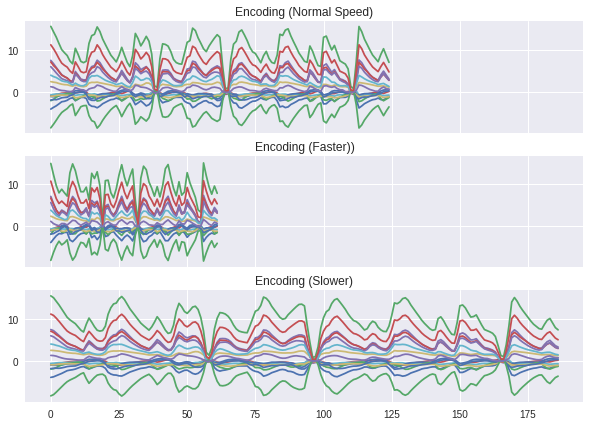

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(encoding[0]); 
axs[0].set_title('Encoding (Normal Speed)')
axs[1].plot(encoding_faster[0]);
axs[1].set_title('Encoding (Faster))')
axs[2].plot(encoding_slower[0]);
axs[2].set_title('Encoding (Slower)')

Now let's decode them:

In [0]:
fastgen.synthesize(encoding_faster, save_paths=['gen_faster_' + fname])
fastgen.synthesize(encoding_slower, save_paths=['gen_slower_' + fname])

INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample

INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 7100
INFO:tensorflow:Sample: 7200
INFO:tensorflow:Sample: 7300
INFO:tensorflow:Sample: 7400
INFO:tensorflow:Sample: 7500
INFO:tensorflow:Sample: 7600
INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorf

INFO:tensorflow:Sample: 14200
INFO:tensorflow:Sample: 14300
INFO:tensorflow:Sample: 14400
INFO:tensorflow:Sample: 14500
INFO:tensorflow:Sample: 14600
INFO:tensorflow:Sample: 14700
INFO:tensorflow:Sample: 14800
INFO:tensorflow:Sample: 14900
INFO:tensorflow:Sample: 15000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 15100
INFO:tensorflow:Sample: 15200
INFO:tensorflow:Sample: 15300
INFO:tensorflow:Sample: 15400
INFO:tensorflow:Sample: 15500
INFO:tensorflow:Sample: 15600
INFO:tensorflow:Sample: 15700
INFO:tensorflow:Sample: 15800
INFO:tensorflow:Sample: 15900
INFO:tensorflow:Sample: 16000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Saving: gen_fast

INFO:tensorflow:Sample: 21400
INFO:tensorflow:Sample: 21500
INFO:tensorflow:Sample: 21600
INFO:tensorflow:Sample: 21700
INFO:tensorflow:Sample: 21800
INFO:tensorflow:Sample: 21900
INFO:tensorflow:Sample: 22000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 22100
INFO:tensorflow:Sample: 22200
INFO:tensorflow:Sample: 22300
INFO:tensorflow:Sample: 22400
INFO:tensorflow:Sample: 22500
INFO:tensorflow:Sample: 22600
INFO:tensorflow:Sample: 22700
INFO:tensorflow:Sample: 22800
INFO:tensorflow:Sample: 22900
INFO:tensorflow:Sample: 23000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 23100
INFO:tensorflow:Sample: 23200
INFO:tensorflow:Sample: 23300
INFO:tensorflow:Sample: 23400
INFO:tensorflow:Sample: 23500
INFO:tensorflow:Sample: 23600
INFO:tensorflow:Sample: 23700
INFO:tensorflow:Sample: 23800
INFO:tensorflow:Sample: 23900
INFO:tensorflow:Sample: 24000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 24100
INFO:tensorfl

INFO:tensorflow:Sample: 28600
INFO:tensorflow:Sample: 28700
INFO:tensorflow:Sample: 28800
INFO:tensorflow:Sample: 28900
INFO:tensorflow:Sample: 29000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 29100
INFO:tensorflow:Sample: 29200
INFO:tensorflow:Sample: 29300
INFO:tensorflow:Sample: 29400
INFO:tensorflow:Sample: 29500
INFO:tensorflow:Sample: 29600
INFO:tensorflow:Sample: 29700
INFO:tensorflow:Sample: 29800
INFO:tensorflow:Sample: 29900
INFO:tensorflow:Sample: 30000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 30100
INFO:tensorflow:Sample: 30200
INFO:tensorflow:Sample: 30300
INFO:tensorflow:Sample: 30400
INFO:tensorflow:Sample: 30500
INFO:tensorflow:Sample: 30600
INFO:tensorflow:Sample: 30700
INFO:tensorflow:Sample: 30800
INFO:tensorflow:Sample: 30900
INFO:tensorflow:Sample: 31000
INFO:tensorflow:Saving: gen_faster_breakbeat.wav
INFO:tensorflow:Sample: 31100
INFO:tensorflow:Sample: 31200
INFO:tensorflow:Sample: 31300
INFO:tensorfl

INFO:tensorflow:Sample: 3700
INFO:tensorflow:Sample: 3800
INFO:tensorflow:Sample: 3900
INFO:tensorflow:Sample: 4000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 4100
INFO:tensorflow:Sample: 4200
INFO:tensorflow:Sample: 4300
INFO:tensorflow:Sample: 4400
INFO:tensorflow:Sample: 4500
INFO:tensorflow:Sample: 4600
INFO:tensorflow:Sample: 4700
INFO:tensorflow:Sample: 4800
INFO:tensorflow:Sample: 4900
INFO:tensorflow:Sample: 5000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 5100
INFO:tensorflow:Sample: 5200
INFO:tensorflow:Sample: 5300
INFO:tensorflow:Sample: 5400
INFO:tensorflow:Sample: 5500
INFO:tensorflow:Sample: 5600
INFO:tensorflow:Sample: 5700
INFO:tensorflow:Sample: 5800
INFO:tensorflow:Sample: 5900
INFO:tensorflow:Sample: 6000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 6100
INFO:tensorflow:Sample: 6200
INFO:tensorflow:Sample: 6300
INFO:tensorflow:Sample: 6400
INFO:tensorflow:Sample: 6500
INFO:tensorf

INFO:tensorflow:Sample: 10900
INFO:tensorflow:Sample: 11000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 11100
INFO:tensorflow:Sample: 11200
INFO:tensorflow:Sample: 11300
INFO:tensorflow:Sample: 11400
INFO:tensorflow:Sample: 11500
INFO:tensorflow:Sample: 11600
INFO:tensorflow:Sample: 11700
INFO:tensorflow:Sample: 11800
INFO:tensorflow:Sample: 11900
INFO:tensorflow:Sample: 12000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 12100
INFO:tensorflow:Sample: 12200
INFO:tensorflow:Sample: 12300
INFO:tensorflow:Sample: 12400
INFO:tensorflow:Sample: 12500
INFO:tensorflow:Sample: 12600
INFO:tensorflow:Sample: 12700
INFO:tensorflow:Sample: 12800
INFO:tensorflow:Sample: 12900
INFO:tensorflow:Sample: 13000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 13100
INFO:tensorflow:Sample: 13200
INFO:tensorflow:Sample: 13300
INFO:tensorflow:Sample: 13400
INFO:tensorflow:Sample: 13500
INFO:tensorflow:Sample: 13600
INFO:tensorfl

INFO:tensorflow:Sample: 18000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 18100
INFO:tensorflow:Sample: 18200
INFO:tensorflow:Sample: 18300
INFO:tensorflow:Sample: 18400
INFO:tensorflow:Sample: 18500
INFO:tensorflow:Sample: 18600
INFO:tensorflow:Sample: 18700
INFO:tensorflow:Sample: 18800
INFO:tensorflow:Sample: 18900
INFO:tensorflow:Sample: 19000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 19100
INFO:tensorflow:Sample: 19200
INFO:tensorflow:Sample: 19300
INFO:tensorflow:Sample: 19400
INFO:tensorflow:Sample: 19500
INFO:tensorflow:Sample: 19600
INFO:tensorflow:Sample: 19700
INFO:tensorflow:Sample: 19800
INFO:tensorflow:Sample: 19900
INFO:tensorflow:Sample: 20000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 20100
INFO:tensorflow:Sample: 20200
INFO:tensorflow:Sample: 20300
INFO:tensorflow:Sample: 20400
INFO:tensorflow:Sample: 20500
INFO:tensorflow:Sample: 20600
INFO:tensorflow:Sample: 20700
INFO:tensorfl

INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 25100
INFO:tensorflow:Sample: 25200
INFO:tensorflow:Sample: 25300
INFO:tensorflow:Sample: 25400
INFO:tensorflow:Sample: 25500
INFO:tensorflow:Sample: 25600
INFO:tensorflow:Sample: 25700
INFO:tensorflow:Sample: 25800
INFO:tensorflow:Sample: 25900
INFO:tensorflow:Sample: 26000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 26100
INFO:tensorflow:Sample: 26200
INFO:tensorflow:Sample: 26300
INFO:tensorflow:Sample: 26400
INFO:tensorflow:Sample: 26500
INFO:tensorflow:Sample: 26600
INFO:tensorflow:Sample: 26700
INFO:tensorflow:Sample: 26800
INFO:tensorflow:Sample: 26900
INFO:tensorflow:Sample: 27000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 27100
INFO:tensorflow:Sample: 27200
INFO:tensorflow:Sample: 27300
INFO:tensorflow:Sample: 27400
INFO:tensorflow:Sample: 27500
INFO:tensorflow:Sample: 27600
INFO:tensorflow:Sample: 27700
INFO:tensorflow:Sample: 27800
INFO:tensorfl

INFO:tensorflow:Sample: 32100
INFO:tensorflow:Sample: 32200
INFO:tensorflow:Sample: 32300
INFO:tensorflow:Sample: 32400
INFO:tensorflow:Sample: 32500
INFO:tensorflow:Sample: 32600
INFO:tensorflow:Sample: 32700
INFO:tensorflow:Sample: 32800
INFO:tensorflow:Sample: 32900
INFO:tensorflow:Sample: 33000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 33100
INFO:tensorflow:Sample: 33200
INFO:tensorflow:Sample: 33300
INFO:tensorflow:Sample: 33400
INFO:tensorflow:Sample: 33500
INFO:tensorflow:Sample: 33600
INFO:tensorflow:Sample: 33700
INFO:tensorflow:Sample: 33800
INFO:tensorflow:Sample: 33900
INFO:tensorflow:Sample: 34000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 34100
INFO:tensorflow:Sample: 34200
INFO:tensorflow:Sample: 34300
INFO:tensorflow:Sample: 34400
INFO:tensorflow:Sample: 34500
INFO:tensorflow:Sample: 34600
INFO:tensorflow:Sample: 34700
INFO:tensorflow:Sample: 34800
INFO:tensorflow:Sample: 34900
INFO:tensorflow:Sample: 35000
IN

INFO:tensorflow:Sample: 39300
INFO:tensorflow:Sample: 39400
INFO:tensorflow:Sample: 39500
INFO:tensorflow:Sample: 39600
INFO:tensorflow:Sample: 39700
INFO:tensorflow:Sample: 39800
INFO:tensorflow:Sample: 39900
INFO:tensorflow:Sample: 40000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 40100
INFO:tensorflow:Sample: 40200
INFO:tensorflow:Sample: 40300
INFO:tensorflow:Sample: 40400
INFO:tensorflow:Sample: 40500
INFO:tensorflow:Sample: 40600
INFO:tensorflow:Sample: 40700
INFO:tensorflow:Sample: 40800
INFO:tensorflow:Sample: 40900
INFO:tensorflow:Sample: 41000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 41100
INFO:tensorflow:Sample: 41200
INFO:tensorflow:Sample: 41300
INFO:tensorflow:Sample: 41400
INFO:tensorflow:Sample: 41500
INFO:tensorflow:Sample: 41600
INFO:tensorflow:Sample: 41700
INFO:tensorflow:Sample: 41800
INFO:tensorflow:Sample: 41900
INFO:tensorflow:Sample: 42000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorfl

INFO:tensorflow:Sample: 46500
INFO:tensorflow:Sample: 46600
INFO:tensorflow:Sample: 46700
INFO:tensorflow:Sample: 46800
INFO:tensorflow:Sample: 46900
INFO:tensorflow:Sample: 47000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 47100
INFO:tensorflow:Sample: 47200
INFO:tensorflow:Sample: 47300
INFO:tensorflow:Sample: 47400
INFO:tensorflow:Sample: 47500
INFO:tensorflow:Sample: 47600
INFO:tensorflow:Sample: 47700
INFO:tensorflow:Sample: 47800
INFO:tensorflow:Sample: 47900
INFO:tensorflow:Sample: 48000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 48100
INFO:tensorflow:Sample: 48200
INFO:tensorflow:Sample: 48300
INFO:tensorflow:Sample: 48400
INFO:tensorflow:Sample: 48500
INFO:tensorflow:Sample: 48600
INFO:tensorflow:Sample: 48700
INFO:tensorflow:Sample: 48800
INFO:tensorflow:Sample: 48900
INFO:tensorflow:Sample: 49000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 49100
INFO:tensorflow:Sample: 49200
INFO:tensorfl

INFO:tensorflow:Sample: 53600
INFO:tensorflow:Sample: 53700
INFO:tensorflow:Sample: 53800
INFO:tensorflow:Sample: 53900
INFO:tensorflow:Sample: 54000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 54100
INFO:tensorflow:Sample: 54200
INFO:tensorflow:Sample: 54300
INFO:tensorflow:Sample: 54400
INFO:tensorflow:Sample: 54500
INFO:tensorflow:Sample: 54600
INFO:tensorflow:Sample: 54700
INFO:tensorflow:Sample: 54800
INFO:tensorflow:Sample: 54900
INFO:tensorflow:Sample: 55000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 55100
INFO:tensorflow:Sample: 55200
INFO:tensorflow:Sample: 55300
INFO:tensorflow:Sample: 55400
INFO:tensorflow:Sample: 55500
INFO:tensorflow:Sample: 55600
INFO:tensorflow:Sample: 55700
INFO:tensorflow:Sample: 55800
INFO:tensorflow:Sample: 55900
INFO:tensorflow:Sample: 56000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 56100
INFO:tensorflow:Sample: 56200
INFO:tensorflow:Sample: 56300
INFO:tensorfl

INFO:tensorflow:Sample: 60700
INFO:tensorflow:Sample: 60800
INFO:tensorflow:Sample: 60900
INFO:tensorflow:Sample: 61000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 61100
INFO:tensorflow:Sample: 61200
INFO:tensorflow:Sample: 61300
INFO:tensorflow:Sample: 61400
INFO:tensorflow:Sample: 61500
INFO:tensorflow:Sample: 61600
INFO:tensorflow:Sample: 61700
INFO:tensorflow:Sample: 61800
INFO:tensorflow:Sample: 61900
INFO:tensorflow:Sample: 62000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 62100
INFO:tensorflow:Sample: 62200
INFO:tensorflow:Sample: 62300
INFO:tensorflow:Sample: 62400
INFO:tensorflow:Sample: 62500
INFO:tensorflow:Sample: 62600
INFO:tensorflow:Sample: 62700
INFO:tensorflow:Sample: 62800
INFO:tensorflow:Sample: 62900
INFO:tensorflow:Sample: 63000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 63100
INFO:tensorflow:Sample: 63200
INFO:tensorflow:Sample: 63300
INFO:tensorflow:Sample: 63400
INFO:tensorfl

INFO:tensorflow:Sample: 67800
INFO:tensorflow:Sample: 67900
INFO:tensorflow:Sample: 68000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 68100
INFO:tensorflow:Sample: 68200
INFO:tensorflow:Sample: 68300
INFO:tensorflow:Sample: 68400
INFO:tensorflow:Sample: 68500
INFO:tensorflow:Sample: 68600
INFO:tensorflow:Sample: 68700
INFO:tensorflow:Sample: 68800
INFO:tensorflow:Sample: 68900
INFO:tensorflow:Sample: 69000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 69100
INFO:tensorflow:Sample: 69200
INFO:tensorflow:Sample: 69300
INFO:tensorflow:Sample: 69400
INFO:tensorflow:Sample: 69500
INFO:tensorflow:Sample: 69600
INFO:tensorflow:Sample: 69700
INFO:tensorflow:Sample: 69800
INFO:tensorflow:Sample: 69900
INFO:tensorflow:Sample: 70000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 70100
INFO:tensorflow:Sample: 70200
INFO:tensorflow:Sample: 70300
INFO:tensorflow:Sample: 70400
INFO:tensorflow:Sample: 70500
INFO:tensorfl

INFO:tensorflow:Sample: 74900
INFO:tensorflow:Sample: 75000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 75100
INFO:tensorflow:Sample: 75200
INFO:tensorflow:Sample: 75300
INFO:tensorflow:Sample: 75400
INFO:tensorflow:Sample: 75500
INFO:tensorflow:Sample: 75600
INFO:tensorflow:Sample: 75700
INFO:tensorflow:Sample: 75800
INFO:tensorflow:Sample: 75900
INFO:tensorflow:Sample: 76000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 76100
INFO:tensorflow:Sample: 76200
INFO:tensorflow:Sample: 76300
INFO:tensorflow:Sample: 76400
INFO:tensorflow:Sample: 76500
INFO:tensorflow:Sample: 76600
INFO:tensorflow:Sample: 76700
INFO:tensorflow:Sample: 76800
INFO:tensorflow:Sample: 76900
INFO:tensorflow:Sample: 77000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 77100
INFO:tensorflow:Sample: 77200
INFO:tensorflow:Sample: 77300
INFO:tensorflow:Sample: 77400
INFO:tensorflow:Sample: 77500
INFO:tensorflow:Sample: 77600
INFO:tensorfl

INFO:tensorflow:Sample: 82000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 82100
INFO:tensorflow:Sample: 82200
INFO:tensorflow:Sample: 82300
INFO:tensorflow:Sample: 82400
INFO:tensorflow:Sample: 82500
INFO:tensorflow:Sample: 82600
INFO:tensorflow:Sample: 82700
INFO:tensorflow:Sample: 82800
INFO:tensorflow:Sample: 82900
INFO:tensorflow:Sample: 83000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 83100
INFO:tensorflow:Sample: 83200
INFO:tensorflow:Sample: 83300
INFO:tensorflow:Sample: 83400
INFO:tensorflow:Sample: 83500
INFO:tensorflow:Sample: 83600
INFO:tensorflow:Sample: 83700
INFO:tensorflow:Sample: 83800
INFO:tensorflow:Sample: 83900
INFO:tensorflow:Sample: 84000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 84100
INFO:tensorflow:Sample: 84200
INFO:tensorflow:Sample: 84300
INFO:tensorflow:Sample: 84400
INFO:tensorflow:Sample: 84500
INFO:tensorflow:Sample: 84600
INFO:tensorflow:Sample: 84700
INFO:tensorfl

INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 89100
INFO:tensorflow:Sample: 89200
INFO:tensorflow:Sample: 89300
INFO:tensorflow:Sample: 89400
INFO:tensorflow:Sample: 89500
INFO:tensorflow:Sample: 89600
INFO:tensorflow:Sample: 89700
INFO:tensorflow:Sample: 89800
INFO:tensorflow:Sample: 89900
INFO:tensorflow:Sample: 90000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 90100
INFO:tensorflow:Sample: 90200
INFO:tensorflow:Sample: 90300
INFO:tensorflow:Sample: 90400
INFO:tensorflow:Sample: 90500
INFO:tensorflow:Sample: 90600
INFO:tensorflow:Sample: 90700
INFO:tensorflow:Sample: 90800
INFO:tensorflow:Sample: 90900
INFO:tensorflow:Sample: 91000
INFO:tensorflow:Saving: gen_slower_breakbeat.wav
INFO:tensorflow:Sample: 91100
INFO:tensorflow:Sample: 91200
INFO:tensorflow:Sample: 91300
INFO:tensorflow:Sample: 91400
INFO:tensorflow:Sample: 91500
INFO:tensorflow:Sample: 91600
INFO:tensorflow:Sample: 91700
INFO:tensorflow:Sample: 91800
INFO:tensorfl

In [0]:
Audio(utils.load_audio('gen_faster_' + fname, sample_length, sr), rate=sr)

In [0]:
Audio(utils.load_audio('gen_slower_' + fname, sample_length, sr), rate=sr)

It seems to work pretty well and retains the pitch and timbre of the original sound.  We could even quickly layer the sounds just by adding them.  You might want to do this in a program like Logic or Ableton Live instead and explore more possiblities of these sounds!

# Part 3: Interpolating Sounds

Now let's try something more experimental.  NSynth released plenty of great examples of what happens when you mix the embeddings of different sounds: https://magenta.tensorflow.org/nsynth-instrument - we're going to do the same but now with our own sounds!

First let's load some encodings:

In [0]:
sample_length = 80000

aud1, enc1 = load_encoding('cello.wav', sample_length)
aud2, enc2 = load_encoding('breakbeat.wav', sample_length)

INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Restoring parameters from model.ckpt-200000


Now we'll mix the two audio signals together.  But this is unlike adding the two signals together in a Ableton or simply hearing both sounds at the same time.  Instead, we're averaging the representation of their timbres, tonality, change over time, and resulting audio signal.  This is way more powerful than a simple averaging.

In [0]:
enc_mix = (enc1 + enc2) / 2.0

Text(0.5,1,'Average')

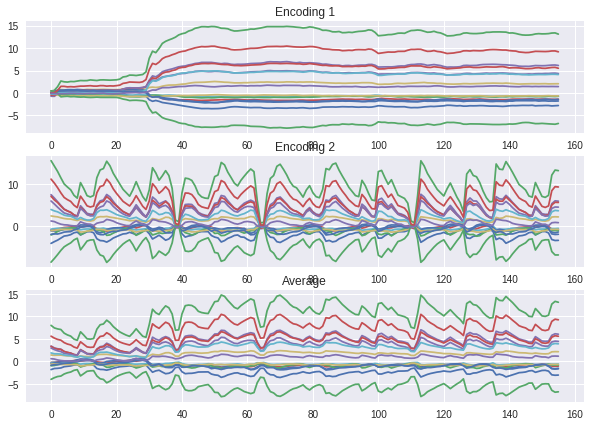

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].plot(enc1[0]); 
axs[0].set_title('Encoding 1')
axs[1].plot(enc2[0]);
axs[1].set_title('Encoding 2')
axs[2].plot(enc_mix[0]);
axs[2].set_title('Average')

In [0]:
fastgen.synthesize(enc_mix, save_paths=['mix.wav'])

INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800
INFO:tensorflow:Sample: 2900
INFO

INFO:tensorflow:Sample: 7300
INFO:tensorflow:Sample: 7400
INFO:tensorflow:Sample: 7500
INFO:tensorflow:Sample: 7600
INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorflow:Sample: 10000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 10100
INFO:tensorflow:Sample: 10200
INFO:tensorflow:Sample: 10300
INFO:tensorflow:Sam

INFO:tensorflow:Sample: 14800
INFO:tensorflow:Sample: 14900
INFO:tensorflow:Sample: 15000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 15100
INFO:tensorflow:Sample: 15200
INFO:tensorflow:Sample: 15300
INFO:tensorflow:Sample: 15400
INFO:tensorflow:Sample: 15500
INFO:tensorflow:Sample: 15600
INFO:tensorflow:Sample: 15700
INFO:tensorflow:Sample: 15800
INFO:tensorflow:Sample: 15900
INFO:tensorflow:Sample: 16000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 17100
INFO:tensorflow:Sample: 17200
INFO:tensorflow:Sample: 17300
INFO:tensorflow:Sample: 17400
INFO:tensorflow:Sample: 17500
INFO:tensorflow:Sample: 17600
INFO:tensorflow:Sample: 17700
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 22100
INFO:tensorflow:Sample: 22200
INFO:tensorflow:Sample: 22300
INFO:tensorflow:Sample: 22400
INFO:tensorflow:Sample: 22500
INFO:tensorflow:Sample: 22600
INFO:tensorflow:Sample: 22700
INFO:tensorflow:Sample: 22800
INFO:tensorflow:Sample: 22900
INFO:tensorflow:Sample: 23000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 23100
INFO:tensorflow:Sample: 23200
INFO:tensorflow:Sample: 23300
INFO:tensorflow:Sample: 23400
INFO:tensorflow:Sample: 23500
INFO:tensorflow:Sample: 23600
INFO:tensorflow:Sample: 23700
INFO:tensorflow:Sample: 23800
INFO:tensorflow:Sample: 23900
INFO:tensorflow:Sample: 24000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 24100
INFO:tensorflow:Sample: 24200
INFO:tensorflow:Sample: 24300
INFO:tensorflow:Sample: 24400
INFO:tensorflow:Sample: 24500
INFO:tensorflow:Sample: 24600
INFO:tensorflow:Sample: 24700
INFO:tensorflow:Sample: 24800
INFO:tensorflow:Sample: 24900
INFO:tensorflow:Sample: 25000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 29500
INFO:tensorflow:Sample: 29600
INFO:tensorflow:Sample: 29700
INFO:tensorflow:Sample: 29800
INFO:tensorflow:Sample: 29900
INFO:tensorflow:Sample: 30000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 30100
INFO:tensorflow:Sample: 30200
INFO:tensorflow:Sample: 30300
INFO:tensorflow:Sample: 30400
INFO:tensorflow:Sample: 30500
INFO:tensorflow:Sample: 30600
INFO:tensorflow:Sample: 30700
INFO:tensorflow:Sample: 30800
INFO:tensorflow:Sample: 30900
INFO:tensorflow:Sample: 31000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 31100
INFO:tensorflow:Sample: 31200
INFO:tensorflow:Sample: 31300
INFO:tensorflow:Sample: 31400
INFO:tensorflow:Sample: 31500
INFO:tensorflow:Sample: 31600
INFO:tensorflow:Sample: 31700
INFO:tensorflow:Sample: 31800
INFO:tensorflow:Sample: 31900
INFO:tensorflow:Sample: 32000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 32100
INFO:tensorflow:Sample: 32200
INFO:tensorflow:Sample: 32300
INFO:tensorflow:Sample: 32400
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 36900
INFO:tensorflow:Sample: 37000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 37100
INFO:tensorflow:Sample: 37200
INFO:tensorflow:Sample: 37300
INFO:tensorflow:Sample: 37400
INFO:tensorflow:Sample: 37500
INFO:tensorflow:Sample: 37600
INFO:tensorflow:Sample: 37700
INFO:tensorflow:Sample: 37800
INFO:tensorflow:Sample: 37900
INFO:tensorflow:Sample: 38000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 38100
INFO:tensorflow:Sample: 38200
INFO:tensorflow:Sample: 38300
INFO:tensorflow:Sample: 38400
INFO:tensorflow:Sample: 38500
INFO:tensorflow:Sample: 38600
INFO:tensorflow:Sample: 38700
INFO:tensorflow:Sample: 38800
INFO:tensorflow:Sample: 38900
INFO:tensorflow:Sample: 39000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 39100
INFO:tensorflow:Sample: 39200
INFO:tensorflow:Sample: 39300
INFO:tensorflow:Sample: 39400
INFO:tensorflow:Sample: 39500
INFO:tensorflow:Sample: 39600
INFO:tensorflow:Sample: 39700
INFO:tensorflow:Sample: 39800
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 44200
INFO:tensorflow:Sample: 44300
INFO:tensorflow:Sample: 44400
INFO:tensorflow:Sample: 44500
INFO:tensorflow:Sample: 44600
INFO:tensorflow:Sample: 44700
INFO:tensorflow:Sample: 44800
INFO:tensorflow:Sample: 44900
INFO:tensorflow:Sample: 45000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 45100
INFO:tensorflow:Sample: 45200
INFO:tensorflow:Sample: 45300
INFO:tensorflow:Sample: 45400
INFO:tensorflow:Sample: 45500
INFO:tensorflow:Sample: 45600
INFO:tensorflow:Sample: 45700
INFO:tensorflow:Sample: 45800
INFO:tensorflow:Sample: 45900
INFO:tensorflow:Sample: 46000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 46100
INFO:tensorflow:Sample: 46200
INFO:tensorflow:Sample: 46300
INFO:tensorflow:Sample: 46400
INFO:tensorflow:Sample: 46500
INFO:tensorflow:Sample: 46600
INFO:tensorflow:Sample: 46700
INFO:tensorflow:Sample: 46800
INFO:tensorflow:Sample: 46900
INFO:tensorflow:Sample: 47000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 47100
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 51600
INFO:tensorflow:Sample: 51700
INFO:tensorflow:Sample: 51800
INFO:tensorflow:Sample: 51900
INFO:tensorflow:Sample: 52000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 52100
INFO:tensorflow:Sample: 52200
INFO:tensorflow:Sample: 52300
INFO:tensorflow:Sample: 52400
INFO:tensorflow:Sample: 52500
INFO:tensorflow:Sample: 52600
INFO:tensorflow:Sample: 52700
INFO:tensorflow:Sample: 52800
INFO:tensorflow:Sample: 52900
INFO:tensorflow:Sample: 53000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 53100
INFO:tensorflow:Sample: 53200
INFO:tensorflow:Sample: 53300
INFO:tensorflow:Sample: 53400
INFO:tensorflow:Sample: 53500
INFO:tensorflow:Sample: 53600
INFO:tensorflow:Sample: 53700
INFO:tensorflow:Sample: 53800
INFO:tensorflow:Sample: 53900
INFO:tensorflow:Sample: 54000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 54100
INFO:tensorflow:Sample: 54200
INFO:tensorflow:Sample: 54300
INFO:tensorflow:Sample: 54400
INFO:tensorflow:Sample: 54500
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 59000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 59100
INFO:tensorflow:Sample: 59200
INFO:tensorflow:Sample: 59300
INFO:tensorflow:Sample: 59400
INFO:tensorflow:Sample: 59500
INFO:tensorflow:Sample: 59600
INFO:tensorflow:Sample: 59700
INFO:tensorflow:Sample: 59800
INFO:tensorflow:Sample: 59900
INFO:tensorflow:Sample: 60000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 60100
INFO:tensorflow:Sample: 60200
INFO:tensorflow:Sample: 60300
INFO:tensorflow:Sample: 60400
INFO:tensorflow:Sample: 60500
INFO:tensorflow:Sample: 60600
INFO:tensorflow:Sample: 60700
INFO:tensorflow:Sample: 60800
INFO:tensorflow:Sample: 60900
INFO:tensorflow:Sample: 61000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 61100
INFO:tensorflow:Sample: 61200
INFO:tensorflow:Sample: 61300
INFO:tensorflow:Sample: 61400
INFO:tensorflow:Sample: 61500
INFO:tensorflow:Sample: 61600
INFO:tensorflow:Sample: 61700
INFO:tensorflow:Sample: 61800
INFO:tensorflow:Sample: 61900
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 66300
INFO:tensorflow:Sample: 66400
INFO:tensorflow:Sample: 66500
INFO:tensorflow:Sample: 66600
INFO:tensorflow:Sample: 66700
INFO:tensorflow:Sample: 66800
INFO:tensorflow:Sample: 66900
INFO:tensorflow:Sample: 67000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 67100
INFO:tensorflow:Sample: 67200
INFO:tensorflow:Sample: 67300
INFO:tensorflow:Sample: 67400
INFO:tensorflow:Sample: 67500
INFO:tensorflow:Sample: 67600
INFO:tensorflow:Sample: 67700
INFO:tensorflow:Sample: 67800
INFO:tensorflow:Sample: 67900
INFO:tensorflow:Sample: 68000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 68100
INFO:tensorflow:Sample: 68200
INFO:tensorflow:Sample: 68300
INFO:tensorflow:Sample: 68400
INFO:tensorflow:Sample: 68500
INFO:tensorflow:Sample: 68600
INFO:tensorflow:Sample: 68700
INFO:tensorflow:Sample: 68800
INFO:tensorflow:Sample: 68900
INFO:tensorflow:Sample: 69000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 69100
INFO:tensorflow:Sample: 69200
INFO:tensorflow:Sample

INFO:tensorflow:Sample: 73700
INFO:tensorflow:Sample: 73800
INFO:tensorflow:Sample: 73900
INFO:tensorflow:Sample: 74000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 74100
INFO:tensorflow:Sample: 74200
INFO:tensorflow:Sample: 74300
INFO:tensorflow:Sample: 74400
INFO:tensorflow:Sample: 74500
INFO:tensorflow:Sample: 74600
INFO:tensorflow:Sample: 74700
INFO:tensorflow:Sample: 74800
INFO:tensorflow:Sample: 74900
INFO:tensorflow:Sample: 75000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 75100
INFO:tensorflow:Sample: 75200
INFO:tensorflow:Sample: 75300
INFO:tensorflow:Sample: 75400
INFO:tensorflow:Sample: 75500
INFO:tensorflow:Sample: 75600
INFO:tensorflow:Sample: 75700
INFO:tensorflow:Sample: 75800
INFO:tensorflow:Sample: 75900
INFO:tensorflow:Sample: 76000
INFO:tensorflow:Saving: m
INFO:tensorflow:Sample: 76100
INFO:tensorflow:Sample: 76200
INFO:tensorflow:Sample: 76300
INFO:tensorflow:Sample: 76400
INFO:tensorflow:Sample: 76500
INFO:tensorflow:Sample: 76600
INFO:tensorflow:Sample

In [0]:
Audio(utils.load_audio('mix.wav', sample_length, sr), rate=sr)

As another example of what's possible with interpolation of embeddings, we'll try crossfading between the two embeddings.  To do this, we'll write a utility function which will use a hanning window to apply a fade in or out to the embeddings matrix:

In [0]:
def fade(encoding, mode='in'):
    length = encoding.shape[1]
    fadein = (0.5 * (1.0 - np.cos(3.1415 * np.arange(length) / 
                                  float(length)))).reshape(1, -1, 1)
    if mode == 'in':
        return fadein * encoding
    else:
        return (1.0 - fadein) * encoding

Text(0.5,1,'Fade Out')

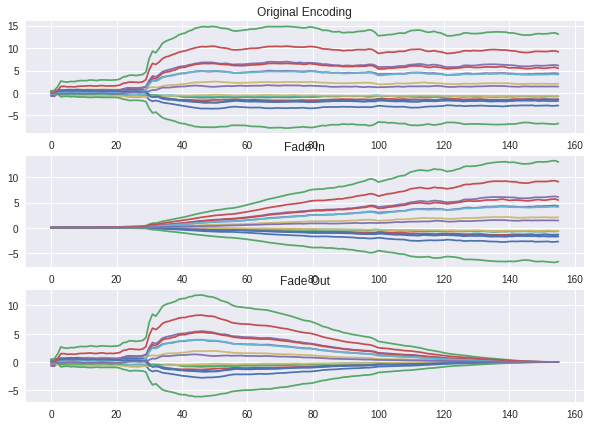

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].plot(enc1[0]); 
axs[0].set_title('Original Encoding')
axs[1].plot(fade(enc1, 'in')[0]);
axs[1].set_title('Fade In')
axs[2].plot(fade(enc1, 'out')[0]);
axs[2].set_title('Fade Out')

Now we can cross fade two different encodings by adding their repsective fade ins and out:

In [0]:
def crossfade(encoding1, encoding2):
    return fade(encoding1, 'out') + fade(encoding2, 'in')

Text(0.5,1,'Crossfade')

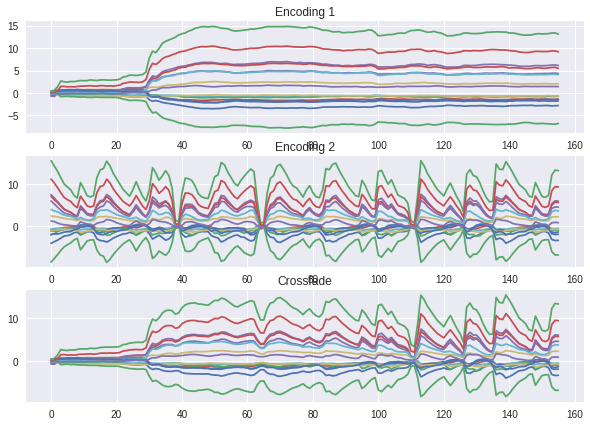

In [0]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7))
axs[0].plot(enc1[0]); 
axs[0].set_title('Encoding 1')
axs[1].plot(enc2[0]);
axs[1].set_title('Encoding 2')
axs[2].plot(crossfade(enc1, enc2)[0]);
axs[2].set_title('Crossfade')

Now let's synthesize the resulting encodings:

In [0]:
fastgen.synthesize(crossfade(enc1, enc2), save_paths=['crossfade.wav'])

INFO:tensorflow:Restoring parameters from model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 28

INFO:tensorflow:Sample: 7100
INFO:tensorflow:Sample: 7200
INFO:tensorflow:Sample: 7300
INFO:tensorflow:Sample: 7400
INFO:tensorflow:Sample: 7500
INFO:tensorflow:Sample: 7600
INFO:tensorflow:Sample: 7700
INFO:tensorflow:Sample: 7800
INFO:tensorflow:Sample: 7900
INFO:tensorflow:Sample: 8000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 8100
INFO:tensorflow:Sample: 8200
INFO:tensorflow:Sample: 8300
INFO:tensorflow:Sample: 8400
INFO:tensorflow:Sample: 8500
INFO:tensorflow:Sample: 8600
INFO:tensorflow:Sample: 8700
INFO:tensorflow:Sample: 8800
INFO:tensorflow:Sample: 8900
INFO:tensorflow:Sample: 9000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 9100
INFO:tensorflow:Sample: 9200
INFO:tensorflow:Sample: 9300
INFO:tensorflow:Sample: 9400
INFO:tensorflow:Sample: 9500
INFO:tensorflow:Sample: 9600
INFO:tensorflow:Sample: 9700
INFO:tensorflow:Sample: 9800
INFO:tensorflow:Sample: 9900
INFO:tensorflow:Sample: 10000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow

INFO:tensorflow:Sample: 14500
INFO:tensorflow:Sample: 14600
INFO:tensorflow:Sample: 14700
INFO:tensorflow:Sample: 14800
INFO:tensorflow:Sample: 14900
INFO:tensorflow:Sample: 15000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 15100
INFO:tensorflow:Sample: 15200
INFO:tensorflow:Sample: 15300
INFO:tensorflow:Sample: 15400
INFO:tensorflow:Sample: 15500
INFO:tensorflow:Sample: 15600
INFO:tensorflow:Sample: 15700
INFO:tensorflow:Sample: 15800
INFO:tensorflow:Sample: 15900
INFO:tensorflow:Sample: 16000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 17100
INFO:tensorflow:Sample: 17200
INFO:tensorflow:Sample: 17300
INFO:tensorflow:

INFO:tensorflow:Sample: 21800
INFO:tensorflow:Sample: 21900
INFO:tensorflow:Sample: 22000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 22100
INFO:tensorflow:Sample: 22200
INFO:tensorflow:Sample: 22300
INFO:tensorflow:Sample: 22400
INFO:tensorflow:Sample: 22500
INFO:tensorflow:Sample: 22600
INFO:tensorflow:Sample: 22700
INFO:tensorflow:Sample: 22800
INFO:tensorflow:Sample: 22900
INFO:tensorflow:Sample: 23000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 23100
INFO:tensorflow:Sample: 23200
INFO:tensorflow:Sample: 23300
INFO:tensorflow:Sample: 23400
INFO:tensorflow:Sample: 23500
INFO:tensorflow:Sample: 23600
INFO:tensorflow:Sample: 23700
INFO:tensorflow:Sample: 23800
INFO:tensorflow:Sample: 23900
INFO:tensorflow:Sample: 24000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 24100
INFO:tensorflow:Sample: 24200
INFO:tensorflow:Sample: 24300
INFO:tensorflow:Sample: 24400
INFO:tensorflow:Sample: 24500
INFO:tensorflow:Sample: 24600
INFO:tensorflow:

INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 29100
INFO:tensorflow:Sample: 29200
INFO:tensorflow:Sample: 29300
INFO:tensorflow:Sample: 29400
INFO:tensorflow:Sample: 29500
INFO:tensorflow:Sample: 29600
INFO:tensorflow:Sample: 29700
INFO:tensorflow:Sample: 29800
INFO:tensorflow:Sample: 29900
INFO:tensorflow:Sample: 30000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 30100
INFO:tensorflow:Sample: 30200
INFO:tensorflow:Sample: 30300
INFO:tensorflow:Sample: 30400
INFO:tensorflow:Sample: 30500
INFO:tensorflow:Sample: 30600
INFO:tensorflow:Sample: 30700
INFO:tensorflow:Sample: 30800
INFO:tensorflow:Sample: 30900
INFO:tensorflow:Sample: 31000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 31100
INFO:tensorflow:Sample: 31200
INFO:tensorflow:Sample: 31300
INFO:tensorflow:Sample: 31400
INFO:tensorflow:Sample: 31500
INFO:tensorflow:Sample: 31600
INFO:tensorflow:Sample: 31700
INFO:tensorflow:Sample: 31800
INFO:tensorflow:Sample: 31900
INFO:tensorflow:

INFO:tensorflow:Sample: 36300
INFO:tensorflow:Sample: 36400
INFO:tensorflow:Sample: 36500
INFO:tensorflow:Sample: 36600
INFO:tensorflow:Sample: 36700
INFO:tensorflow:Sample: 36800
INFO:tensorflow:Sample: 36900
INFO:tensorflow:Sample: 37000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 37100
INFO:tensorflow:Sample: 37200
INFO:tensorflow:Sample: 37300
INFO:tensorflow:Sample: 37400
INFO:tensorflow:Sample: 37500
INFO:tensorflow:Sample: 37600
INFO:tensorflow:Sample: 37700
INFO:tensorflow:Sample: 37800
INFO:tensorflow:Sample: 37900
INFO:tensorflow:Sample: 38000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 38100
INFO:tensorflow:Sample: 38200
INFO:tensorflow:Sample: 38300
INFO:tensorflow:Sample: 38400
INFO:tensorflow:Sample: 38500
INFO:tensorflow:Sample: 38600
INFO:tensorflow:Sample: 38700
INFO:tensorflow:Sample: 38800
INFO:tensorflow:Sample: 38900
INFO:tensorflow:Sample: 39000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 39100
INFO:tensorflow:

INFO:tensorflow:Sample: 43600
INFO:tensorflow:Sample: 43700
INFO:tensorflow:Sample: 43800
INFO:tensorflow:Sample: 43900
INFO:tensorflow:Sample: 44000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 44100
INFO:tensorflow:Sample: 44200
INFO:tensorflow:Sample: 44300
INFO:tensorflow:Sample: 44400
INFO:tensorflow:Sample: 44500
INFO:tensorflow:Sample: 44600
INFO:tensorflow:Sample: 44700
INFO:tensorflow:Sample: 44800
INFO:tensorflow:Sample: 44900
INFO:tensorflow:Sample: 45000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 45100
INFO:tensorflow:Sample: 45200
INFO:tensorflow:Sample: 45300
INFO:tensorflow:Sample: 45400
INFO:tensorflow:Sample: 45500
INFO:tensorflow:Sample: 45600
INFO:tensorflow:Sample: 45700
INFO:tensorflow:Sample: 45800
INFO:tensorflow:Sample: 45900
INFO:tensorflow:Sample: 46000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 46100
INFO:tensorflow:Sample: 46200
INFO:tensorflow:Sample: 46300
INFO:tensorflow:Sample: 46400
INFO:tensorflow:

INFO:tensorflow:Sample: 50900
INFO:tensorflow:Sample: 51000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 51100
INFO:tensorflow:Sample: 51200
INFO:tensorflow:Sample: 51300
INFO:tensorflow:Sample: 51400
INFO:tensorflow:Sample: 51500
INFO:tensorflow:Sample: 51600
INFO:tensorflow:Sample: 51700
INFO:tensorflow:Sample: 51800
INFO:tensorflow:Sample: 51900
INFO:tensorflow:Sample: 52000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 52100
INFO:tensorflow:Sample: 52200
INFO:tensorflow:Sample: 52300
INFO:tensorflow:Sample: 52400
INFO:tensorflow:Sample: 52500
INFO:tensorflow:Sample: 52600
INFO:tensorflow:Sample: 52700
INFO:tensorflow:Sample: 52800
INFO:tensorflow:Sample: 52900
INFO:tensorflow:Sample: 53000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 53100
INFO:tensorflow:Sample: 53200
INFO:tensorflow:Sample: 53300
INFO:tensorflow:Sample: 53400
INFO:tensorflow:Sample: 53500
INFO:tensorflow:Sample: 53600
INFO:tensorflow:Sample: 53700
INFO:tensorflow:

INFO:tensorflow:Sample: 58100
INFO:tensorflow:Sample: 58200
INFO:tensorflow:Sample: 58300
INFO:tensorflow:Sample: 58400
INFO:tensorflow:Sample: 58500
INFO:tensorflow:Sample: 58600
INFO:tensorflow:Sample: 58700
INFO:tensorflow:Sample: 58800
INFO:tensorflow:Sample: 58900
INFO:tensorflow:Sample: 59000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 59100
INFO:tensorflow:Sample: 59200
INFO:tensorflow:Sample: 59300
INFO:tensorflow:Sample: 59400
INFO:tensorflow:Sample: 59500
INFO:tensorflow:Sample: 59600
INFO:tensorflow:Sample: 59700
INFO:tensorflow:Sample: 59800
INFO:tensorflow:Sample: 59900
INFO:tensorflow:Sample: 60000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 60100
INFO:tensorflow:Sample: 60200
INFO:tensorflow:Sample: 60300
INFO:tensorflow:Sample: 60400
INFO:tensorflow:Sample: 60500
INFO:tensorflow:Sample: 60600
INFO:tensorflow:Sample: 60700
INFO:tensorflow:Sample: 60800
INFO:tensorflow:Sample: 60900
INFO:tensorflow:Sample: 61000
INFO:tensorflow:Saving: 

INFO:tensorflow:Sample: 65400
INFO:tensorflow:Sample: 65500
INFO:tensorflow:Sample: 65600
INFO:tensorflow:Sample: 65700
INFO:tensorflow:Sample: 65800
INFO:tensorflow:Sample: 65900
INFO:tensorflow:Sample: 66000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 66100
INFO:tensorflow:Sample: 66200
INFO:tensorflow:Sample: 66300
INFO:tensorflow:Sample: 66400
INFO:tensorflow:Sample: 66500
INFO:tensorflow:Sample: 66600
INFO:tensorflow:Sample: 66700
INFO:tensorflow:Sample: 66800
INFO:tensorflow:Sample: 66900
INFO:tensorflow:Sample: 67000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 67100
INFO:tensorflow:Sample: 67200
INFO:tensorflow:Sample: 67300
INFO:tensorflow:Sample: 67400
INFO:tensorflow:Sample: 67500
INFO:tensorflow:Sample: 67600
INFO:tensorflow:Sample: 67700
INFO:tensorflow:Sample: 67800
INFO:tensorflow:Sample: 67900
INFO:tensorflow:Sample: 68000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 68100
INFO:tensorflow:Sample: 68200
INFO:tensorflow:

INFO:tensorflow:Sample: 72700
INFO:tensorflow:Sample: 72800
INFO:tensorflow:Sample: 72900
INFO:tensorflow:Sample: 73000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 73100
INFO:tensorflow:Sample: 73200
INFO:tensorflow:Sample: 73300
INFO:tensorflow:Sample: 73400
INFO:tensorflow:Sample: 73500
INFO:tensorflow:Sample: 73600
INFO:tensorflow:Sample: 73700
INFO:tensorflow:Sample: 73800
INFO:tensorflow:Sample: 73900
INFO:tensorflow:Sample: 74000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 74100
INFO:tensorflow:Sample: 74200
INFO:tensorflow:Sample: 74300
INFO:tensorflow:Sample: 74400
INFO:tensorflow:Sample: 74500
INFO:tensorflow:Sample: 74600
INFO:tensorflow:Sample: 74700
INFO:tensorflow:Sample: 74800
INFO:tensorflow:Sample: 74900
INFO:tensorflow:Sample: 75000
INFO:tensorflow:Saving: crossfade.wav
INFO:tensorflow:Sample: 75100
INFO:tensorflow:Sample: 75200
INFO:tensorflow:Sample: 75300
INFO:tensorflow:Sample: 75400
INFO:tensorflow:Sample: 75500
INFO:tensorflow:

In [0]:
Audio(utils.load_audio('crossfade.wav', sample_length, sr), rate=sr)

There is a lot to explore with NSynth.  So far I've just shown you a taste of what's possible when you are able to generate your own sounds.  I expect the generation process will soon get much faster, especially with help from the community, and for more unexpected and interesting applications to emerge.  Please keep in touch with whatever you end up creating, either personally via [twitter](https://twitter.com/pkmital), in our [Creative Applications of Deep Learning](https://www.kadenze.com/programs/creative-applications-of-deep-learning-with-tensorflow) community on Kadenze, or the [Magenta Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/magenta-discuss).